# Pants Gender Model

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import feather
from boto.s3.connection import S3Connection
from boto.s3.key import Key
import sys, os
import re
import json
from urllib.request import FancyURLopener
import cv2
import glob
import zipfile
from multiprocessing import Pool
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from keras.layers import Input, Embedding, LSTM, Dense, merge
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras_tqdm import TQDMNotebookCallback
from IPython.display import SVG

init_notebook_mode(connected=True)

Using TensorFlow backend.


In [2]:
KEY_FILE = '..//..//..//data//aws_keys//keys.txt'

f = open(KEY_FILE,'rb')
key_data = str(f.read())
keys = re.findall(pattern='\=([a-zA-Z0-9]*)',string=key_data)

AWS_KEY = keys[0]
AWS_SECRET = keys[1]

del keys

BUCKET = 'imaterialist-challenge'
PATH_TO_DATA = '..//..//..//data//imaterialist//'

labeldf = feather.read_dataframe(PATH_TO_DATA+'labeldf.feather')
task_df = feather.read_dataframe(PATH_TO_DATA+'taskdf.feather')
train_annotations = feather.read_dataframe(PATH_TO_DATA+'train_annotations.feather')

def readImageResized(imageId,size):
    return cv2.resize(cv2.imread(PATH_TO_DATA+imageId+'.jpg'),size)

Y_ = lambda x: 0.7*x + 110



In [3]:
Y_(400)

390.0

In [4]:
size = (400,390)

def plotImageResized(image):
    plt.imshow(cv2.cvtColor(cv2.resize(image, size), cv2.COLOR_BGR2RGB))
    plt.show()
    
def GetImageResized(imageId):
    try:
        appended = [imageId,readImageResized(imageId,size)]
        return(appended)
    except:
        x = 1
        
train_images = []

In [5]:
train_data = pd.merge(pd.merge( train_annotations, task_df, on='taskId' ), labeldf, on = 'labelId')

In [6]:
train_data.head(3)

,imageId,labelId,taskId,taskName,taskName_type,taskName_subtype,labelName
0,1,6,5,dress:decoration,dress,decoration,printed
1,108,6,5,dress:decoration,dress,decoration,printed
2,203,6,5,dress:decoration,dress,decoration,printed


In [7]:
pants_gender_frame = train_data[(train_data['taskName_type'] == 'pants') & (train_data['taskName_subtype'] == 'gender')]

In [8]:
pants_gender_list = list(train_data[(train_data['taskName_type'] == 'pants') & (train_data['taskName_subtype'] == 'gender')]['imageId'])

In [9]:
pants_gender_list

['86',
 '105',
 '322',
 '781',
 '897',
 '1020',
 '1083',
 '1118',
 '1476',
 '1506',
 '1564',
 '1629',
 '1688',
 '2029',
 '2054',
 '2077',
 '2135',
 '2303',
 '2415',
 '2495',
 '2557',
 '2612',
 '3007',
 '3064',
 '3112',
 '3191',
 '3310',
 '3357',
 '3381',
 '3506',
 '3513',
 '3814',
 '3843',
 '3882',
 '3883',
 '4074',
 '4246',
 '4528',
 '4590',
 '4865',
 '4946',
 '5333',
 '5483',
 '5523',
 '5570',
 '5638',
 '5722',
 '5802',
 '5824',
 '5844',
 '5937',
 '5961',
 '5980',
 '6008',
 '6086',
 '6172',
 '6174',
 '6178',
 '6193',
 '6253',
 '6316',
 '6369',
 '6530',
 '6569',
 '6595',
 '6606',
 '6693',
 '6735',
 '6737',
 '6778',
 '7084',
 '7139',
 '7151',
 '7462',
 '7612',
 '7665',
 '7776',
 '8042',
 '8144',
 '8355',
 '8380',
 '8607',
 '8737',
 '9005',
 '9347',
 '9588',
 '9786',
 '9857',
 '9892',
 '9971',
 '10207',
 '10328',
 '10575',
 '10609',
 '10648',
 '10702',
 '11029',
 '11173',
 '11892',
 '12202',
 '12583',
 '12693',
 '12924',
 '13098',
 '13359',
 '13386',
 '13418',
 '13472',
 '13643',
 '1374

In [10]:
pool = Pool()
pool.map_async(GetImageResized, pants_gender_list, callback = train_images.append )
pool.close()
pool.join()

In [11]:
train_images = train_images[0]

In [12]:
image = train_images[0]

In [13]:
def getLabelFromImageId(image):
    return list(pants_gender_frame[pants_gender_frame['imageId'] == image[0]]['labelName'])[0]

In [14]:
train_set = [ [image[0],image[1],getLabelFromImageId(image)] for image in tqdm(train_images) if image != None ]

100%|██████████| 865/865 [00:00<00:00, 1274.46it/s]


In [15]:
np.random.shuffle(train_set)

In [16]:
train_set[:5]

[['28730', array([[[254, 254, 254],
          [254, 254, 254],
          [254, 254, 254],
          ..., 
          [254, 254, 254],
          [254, 254, 254],
          [254, 254, 254]],
  
         [[254, 254, 254],
          [254, 254, 254],
          [254, 254, 254],
          ..., 
          [254, 254, 254],
          [254, 254, 254],
          [254, 254, 254]],
  
         [[254, 254, 254],
          [254, 254, 254],
          [254, 254, 254],
          ..., 
          [254, 254, 254],
          [254, 254, 254],
          [254, 254, 254]],
  
         ..., 
         [[254, 254, 254],
          [254, 254, 254],
          [254, 254, 254],
          ..., 
          [254, 254, 254],
          [254, 254, 254],
          [254, 254, 254]],
  
         [[254, 254, 254],
          [254, 254, 254],
          [254, 254, 254],
          ..., 
          [254, 254, 254],
          [254, 254, 254],
          [254, 254, 254]],
  
         [[254, 254, 254],
          [254, 254, 254],
          [2

In [17]:
#encOH = OneHotEncoder(n_values = 2, sparse=False)
encL = LabelEncoder()

In [18]:
train_x = np.array([obs[1] for obs in train_set])
train_y = encL.fit_transform([obs[2] for obs in train_set])

In [19]:
train_y_onehot = np.zeros((len(train_y),len(np.unique(train_y))))
train_y_onehot[np.arange(len(train_y)), list(train_y)] = 1

In [20]:
train_x = np.array(train_x)
train_y_onehot = np.array(train_y_onehot).astype(float)

In [21]:
np.shape(train_x)

(829, 390, 400, 3)

In [22]:
np.shape(train_y_onehot)

(829, 2)

In [23]:
def plotImage(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

In [24]:
np.shape(train_x[0])

(390, 400, 3)

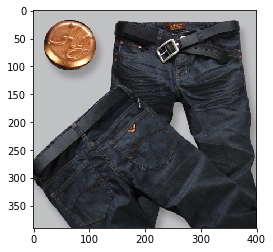

In [25]:
plt.imshow(cv2.cvtColor(train_x[10], cv2.COLOR_BGR2RGB))
plt.show()

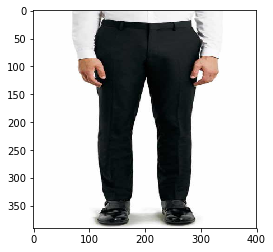

In [26]:
plotImage(train_x[0])

In [34]:
optimizer = RMSprop(lr=1e-6)
objective = 'binary_crossentropy'

model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=[size[1], size[0], 3], activation='relu'))
model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
# model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
# model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])

/home/ubuntu/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning:

Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=[390, 400,..., padding="same", activation="relu")`

/home/ubuntu/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning:

Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`

/home/ubuntu/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning:

Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`

/home/ubuntu/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning:

Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`



In [35]:
nb_epoch = 15
batch_size = 32

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

In [36]:
history = LossHistory()

In [37]:
np.shape(train_x)

(829, 390, 400, 3)

In [38]:
np.shape(train_y_onehot)

(829, 2)

In [ ]:
model.fit(train_x, train_y_onehot, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.08, verbose=1, shuffle=True, callbacks=[history, early_stopping])

Train on 762 samples, validate on 67 samples
Epoch 1/15
762/762 [==============================] - 30s - loss: 5.3688 - acc: 0.4987 - val_loss: 2.3409 - val_acc: 0.4851
Epoch 2/15
762/762 [==============================] - 29s - loss: 4.1119 - acc: 0.4967 - val_loss: 1.5063 - val_acc: 0.4776
Epoch 3/15
762/762 [==============================] - 29s - loss: 2.8089 - acc: 0.5059 - val_loss: 0.7887 - val_acc: 0.5224
Epoch 4/15
762/762 [==============================] - 29s - loss: 1.8696 - acc: 0.4954 - val_loss: 0.7837 - val_acc: 0.5597
Epoch 5/15
762/762 [==============================] - 29s - loss: 1.2243 - acc: 0.5052 - val_loss: 0.7664 - val_acc: 0.4478
Epoch 6/15
256/762 [=========>....................] - ETA: 18s - loss: 0.8973 - acc: 0.4746

In [ ]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()